In [9]:
library(glmnet)
library(dplyr)
library(tidyverse)

In [10]:
train_data <- read.csv("train.csv")
test_data <- read.csv("test.csv", colClasses = c("id" = "character"))

In [11]:
train_data <- train_data %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1)) %>%
    mutate(price = as.numeric(price),
           host_response_rate = as.numeric(host_response_rate),
           host_acceptance_rate = as.numeric(host_acceptance_rate))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


In [12]:
y <- train_data$monthly_revenue
x <- makeX(train_data[ , c('accommodates','beds',
                           'minimum_nights','maximum_nights',
                           'maximum_nights_avg_ntm','availability_30','availability_60','availability_90',
                           'availability_365','number_of_reviews','number_of_reviews_ltm',
                           'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                           'review_scores_value','instant_bookable')],
          na.impute = TRUE)

[1] 6.340339

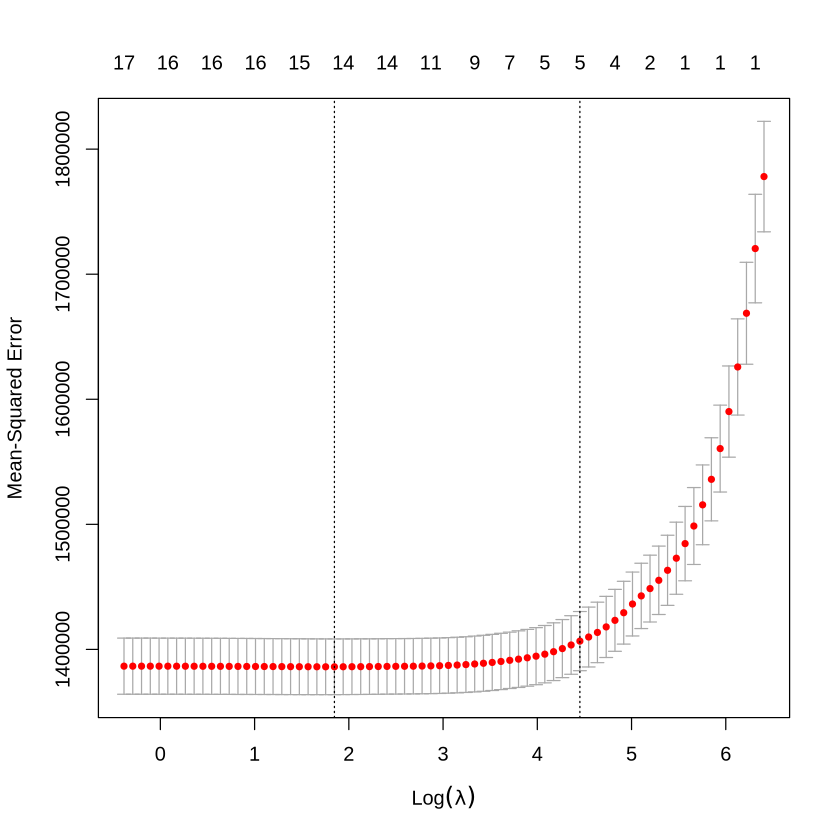

In [13]:
cv_model <- cv.glmnet(x, y, alpha = 1)

best_lambda <- cv_model$lambda.min
best_lambda

plot(cv_model) 

In [14]:
best_model <- glmnet(x, y, alpha = 1, lambda = best_lambda)
coef(best_model)

18 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -1.253769e+03
accommodates               2.480781e+02
beds                       7.964737e+01
minimum_nights            -1.358631e+00
maximum_nights             1.890918e-02
maximum_nights_avg_ntm     4.194508e-02
availability_30            .           
availability_60            .           
availability_90           -6.798770e-02
availability_365          -5.321237e-01
number_of_reviews         -8.130561e-02
number_of_reviews_ltm     -4.161527e-01
review_scores_rating       2.397033e+02
review_scores_accuracy     .           
review_scores_cleanliness  3.458855e+01
review_scores_value        1.616754e+02
instant_bookablef          9.033117e+01
instant_bookablet         -3.309656e-11

In [15]:
pred_y <- predict(best_model, s = best_lambda, newx = x)

sst <- sum((y - mean(y))^2)
sse <- sum((pred_y - y)^2)

rsq <- 1 - sse/sst
rsq
sse 

[1] 0.2272458

[1] 7363865644

In [16]:
head(pred_y)
head(y)

,s1
1,1488.204
2,2269.475
3,2618.305
4,1485.060
5,2093.809
6,1299.889


[1] 2108 2730 2254 3187 3479    0

In [17]:
test_x <- makeX(test_data[ , c(
                           'accommodates','beds',
                           'minimum_nights','maximum_nights',
                           'maximum_nights_avg_ntm','availability_30','availability_60','availability_90',
                           'availability_365','number_of_reviews','number_of_reviews_ltm',
                           'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                           'review_scores_value','instant_bookable')],
          na.impute = TRUE)
test_pred_y <- predict(best_model, s = best_lambda, newx = test_x)

In [18]:
hello <- data.frame(test_data$id, test_pred_y)
colnames(hello) <- c("id", "predictions")
head(hello)

,id,predictions
,<chr>,<dbl>
1,4465400,3348.867
2,608629349064811166,1483.334
3,981894508939312892,2020.392
4,52014961,1959.779
5,836285112356489303,1339.873
6,729730483477613494,2100.476


In [19]:
write.csv(hello, "hello.csv", row.names = FALSE)

**SEPARATE LINEAR REGRESSIONS**

In [44]:
train <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1)) %>%
    mutate(price = as.numeric(price),
           host_response_rate = as.numeric(host_response_rate),
           host_acceptance_rate = as.numeric(host_acceptance_rate))

test <- read.csv("test.csv", colClasses = c("id" = "character"))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


In [45]:
unique(train$property_type)

[1] "Entire home"                        "Entire guest suite"                
 [3] "Entire condo"                       "Entire rental unit"                
 [5] "Entire townhouse"                   "Private room in guest suite"       
 [7] "Private room in home"               "Private room in townhouse"         
 [9] "Private room in condo"              "Private room in rental unit"       
[11] "Entire loft"                        "Entire serviced apartment"         
[13] "Shared room in rental unit"         "Private room in guesthouse"        
[15] "Private room in villa"              "Room in boutique hotel"            
[17] "Entire guesthouse"                  "Casa particular"                   
[19] "Shared room in home"                "Private room in tiny home"         
[21] "Private room in loft"               "Tiny home"                         
[23] "Entire timeshare"                   "Entire vacation home"              
[25] "Camper/RV"                          "Tower"                             
[27] "Entire cabin"                       "Room in aparthotel"                
[29] "Room in bed and breakfast"          "Private room in casa particular"   
[31] "Private room in bed and breakfast"  "Entire villa"                      
[33] "Entire bungalow"                    "Room in hotel"                     
[35] "Entire place"                       "Shared room in condo"              
[37] "Entire cottage"                     "Private room in bungalow"          
[39] "Private room in boat"               "Private room in camper/rv"         
[41] "Boat"                               "Shared room in villa"              
[43] "Private room in serviced apartment" "Private room in castle"            
[45] "Cave"                               "Shared room in loft"

**ENTIRE**

In [36]:
train_e <- train %>%
    filter(grepl("entire", tolower(property_type), fixed = TRUE))

In [37]:
unique(train_e$property_type)

[1] "Entire home"               "Entire guest suite"       
 [3] "Entire condo"              "Entire rental unit"       
 [5] "Entire townhouse"          "Entire loft"              
 [7] "Entire serviced apartment" "Entire guesthouse"        
 [9] "Entire timeshare"          "Entire vacation home"     
[11] "Entire cabin"              "Entire villa"             
[13] "Entire bungalow"           "Entire place"             
[15] "Entire cottage"

**PRIVATE**

In [38]:
train_p <- train %>%
    filter(grepl("private", tolower(property_type), fixed = TRUE))

In [39]:
unique(train_p$property_type)

[1] "Private room in guest suite"        "Private room in home"              
 [3] "Private room in townhouse"          "Private room in condo"             
 [5] "Private room in rental unit"        "Private room in guesthouse"        
 [7] "Private room in villa"              "Private room in tiny home"         
 [9] "Private room in loft"               "Private room in casa particular"   
[11] "Private room in bed and breakfast"  "Private room in bungalow"          
[13] "Private room in boat"               "Private room in camper/rv"         
[15] "Private room in serviced apartment" "Private room in castle"

**SHARED**

In [40]:
train_s <- train %>%
    filter(grepl("shared", tolower(property_type), fixed = TRUE))

In [41]:
unique(train_s$property_type)

[1] "Shared room in rental unit" "Shared room in home"       
[3] "Shared room in condo"       "Shared room in villa"      
[5] "Shared room in loft"

**OTHER**

In [43]:
train_o <- train %>%
    filter(!grepl("shared", tolower(property_type), fixed = TRUE) &
           !grepl("private", tolower(property_type), fixed = TRUE) &
           !grepl("entire", tolower(property_type), fixed = TRUE))
unique(train_o$property_type)

[1] "Room in boutique hotel"    "Casa particular"          
 [3] "Tiny home"                 "Camper/RV"                
 [5] "Tower"                     "Room in aparthotel"       
 [7] "Room in bed and breakfast" "Room in hotel"            
 [9] "Boat"                      "Cave"